# 第四节课作业

### 1.微调环境准备

In [ ]:
# InternStudio 平台中，从本地 clone 一个已有 pytorch 2.0.1 的环境（后续均在该环境执行，若为其他环境可作为参考）
# 进入环境后首先 bash
# 进入环境后首先 bash
# 进入环境后首先 bash
bash
conda create --name personal_assistant --clone=/root/share/conda_envs/internlm-base
# 如果在其他平台：
# conda create --name personal_assistant python=3.10 -y

# 激活环境
conda activate personal_assistant
# 进入家目录 （~的意思是 “当前用户的home路径”）
cd ~
# 创建版本文件夹并进入，以跟随本教程
# personal_assistant用于存放本教程所使用的东西
mkdir /root/personal_assistant && cd /root/personal_assistant
mkdir /root/personal_assistant/xtuner019 && cd /root/personal_assistant/xtuner019

# 拉取 0.1.9 的版本源码
git clone -b v0.1.9  https://github.com/InternLM/xtuner
# 无法访问github的用户请从 gitee 拉取:
# git clone -b v0.1.9 https://gitee.com/Internlm/xtuner

# 进入源码目录
cd xtuner

# 从源码安装 XTuner
pip install -e '.[all]'

### 2.数据准备

In [ ]:
#创建data文件夹用于存放用于训练的数据集
mkdir -p /root/personal_assistant/data && cd /root/personal_assistant/data

在data目录下创建一个json文件personal_assistant.json作为本次微调所使用的数据集。json中内容可参考下方(复制粘贴n次做数据增广，数据量小无法有效微调，下面仅用于展示格式，下面也有生成脚本)
其中conversation表示一次对话的内容，input为输入，即用户会问的问题，output为输出，即想要模型回答的答案。
以下是一个python脚本，用于生成数据集。在data目录下新建一个generate_data.py文件，将以下代码复制进去，然后运行该脚本即可生成数据集。

In [ ]:
import json

# 输入你的名字
name = 'Shengshenlan'
# 重复次数
n = 10000

data = [
    {
        "conversation": [
            {
                "input": "请做一下自我介绍",
                "output": "我是{}的小助手，内在是上海AI实验室书生·浦语的7B大模型哦".format(name)
            }
        ]
    }
]

for i in range(n):
    data.append(data[0])

with open('personal_assistant.json', 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=4)


注意：多生成训练样本有助于模型微调，否则看不出微调前后差别！！！

### 3.配置准备

In [ ]:
#下载模型InternLM-chat-7B,InternStudio 平台的 share 目录下已经为我们准备了全系列的 InternLM 模型，可以使用如下命令复制internlm-chat-7b：
mkdir -p /root/personal_assistant/model/Shanghai_AI_Laboratory
cp -r /root/share/temp/model_repos/internlm-chat-7b /root/personal_assistant/model/Shanghai_AI_Laboratory

#XTuner 提供多个开箱即用的配置文件，用户可以通过下列命令查看：
# 列出所有内置配置
xtuner list-cfg
#拷贝一个配置文件到当前目录：xtuner copy-cfg ${CONFIG_NAME} ${SAVE_PATH} 在本例中：（注意最后有个英文句号，代表复制到当前路径）
xtuner copy-cfg internlm_chat_7b_qlora_oasst1_e3 .


修改拷贝后的文件internlm_chat_7b_qlora_oasst1_e3_copy.py,需要修改的内容:

In [ ]:
# PART 1 中
# 预训练模型存放的位置
pretrained_model_name_or_path = '/root/personal_assistant/model/Shanghai_AI_Laboratory/internlm-chat-7b'

# 微调数据存放的位置
data_path = '/root/personal_assistant/data/personal_assistant.json'

# 训练中最大的文本长度
max_length = 512

# 每一批训练样本的大小
batch_size = 2

# 最大训练轮数
max_epochs = 3

# 验证的频率
evaluation_freq = 90

# 用于评估输出内容的问题（用于评估的问题尽量与数据集的question保持一致）
evaluation_inputs = [ '请介绍一下你自己', '请做一下自我介绍' ]


# PART 3 中
dataset=dict(type=load_dataset, path='json', data_files=dict(train=data_path))
dataset_map_fn=None

注意：1.直接改evaluation_inputs = [ '请介绍一下你自己', '请做一下自我介绍' ]会报错，直接修改[]里的内容即可。

### 4.微调启动

In [ ]:
#训练命令
xtuner train /root/personal_assistant/config/internlm_chat_7b_qlora_oasst1_e3_copy.py

成功训练后会出现以下内容：
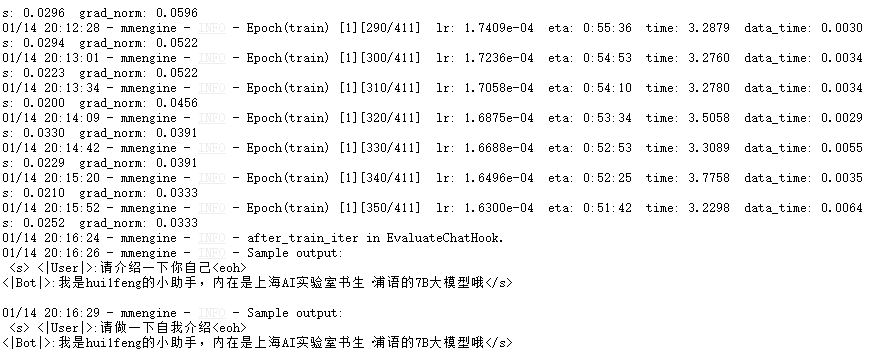

### 5.微调后参数转换/合并

训练后的pth格式参数转Hugging Face格式

In [ ]:

# 创建用于存放Hugging Face格式参数的hf文件夹
mkdir /root/personal_assistant/config/work_dirs/hf

export MKL_SERVICE_FORCE_INTEL=1

# 配置文件存放的位置
export CONFIG_NAME_OR_PATH=/root/personal_assistant/config/internlm_chat_7b_qlora_oasst1_e3_copy.py

# 模型训练后得到的pth格式参数存放的位置
export PTH=/root/personal_assistant/config/work_dirs/internlm_chat_7b_qlora_oasst1_e3_copy/epoch_3.pth

# pth文件转换为Hugging Face格式后参数存放的位置
export SAVE_PATH=/root/personal_assistant/config/work_dirs/hf

# 执行参数转换
xtuner convert pth_to_hf $CONFIG_NAME_OR_PATH $PTH $SAVE_PATH

成功转化后会出现以下内容：

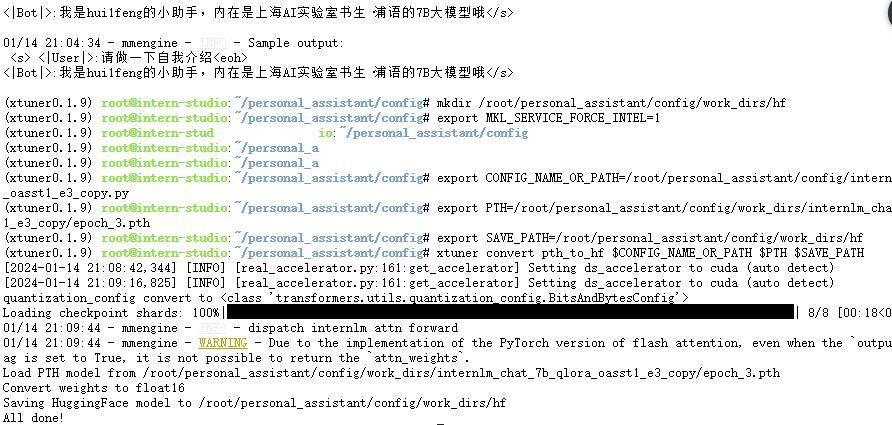

Merge模型参数

In [ ]:
export MKL_SERVICE_FORCE_INTEL=1
export MKL_THREADING_LAYER='GNU'

# 原始模型参数存放的位置
export NAME_OR_PATH_TO_LLM=/root/personal_assistant/model/Shanghai_AI_Laboratory/internlm-chat-7b

# Hugging Face格式参数存放的位置
export NAME_OR_PATH_TO_ADAPTER=/root/personal_assistant/config/work_dirs/hf

# 最终Merge后的参数存放的位置
mkdir /root/personal_assistant/config/work_dirs/hf_merge
export SAVE_PATH=/root/personal_assistant/config/work_dirs/hf_merge

# 执行参数Merge
xtuner convert merge \
    $NAME_OR_PATH_TO_LLM \
    $NAME_OR_PATH_TO_ADAPTER \
    $SAVE_PATH \
    --max-shard-size 2GB

成功转化后会出现以下内容：

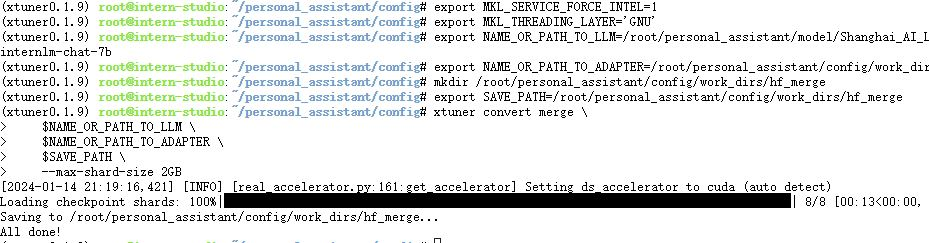

### 6.网页DEMO

In [ ]:
#安装网页Demo所需依赖
pip install streamlit==1.24.0
#下载InternLM项目代码（欢迎Star）
# 创建code文件夹用于存放InternLM项目代码
mkdir /root/personal_assistant/code && cd /root/personal_assistant/code
git clone https://github.com/InternLM/InternLM.git

将 /root/code/InternLM/web_demo.py 中 29 行和 33 行的模型路径更换为Merge后存放参数的路径 /root/personal_assistant/config/work_dirs/hf_merge

运行 /root/personal_assistant/code/InternLM 目录下的 web_demo.py 文件，输入以下命令后，查看本教程5.2配置本地端口后(https://github.com/InternLM/tutorial/blob/main/helloworld/hello_world.md#52-%E9%85%8D%E7%BD%AE%E6%9C%AC%E5%9C%B0%E7%AB%AF%E5%8F%A3)，
将端口映射到本地。在本地浏览器输入 http://127.0.0.1:6006 即可。

In [ ]:
streamlit run /root/personal_assistant/code/InternLM/web_demo.py --server.address 127.0.0.1 --server.port 6006

注意：要在浏览器打开 http://127.0.0.1:6006 页面后，模型才会加载。 在加载完模型之后，就可以与微调后的 InternLM-Chat-7B 进行对话了

### 7.结果呈现

微调前

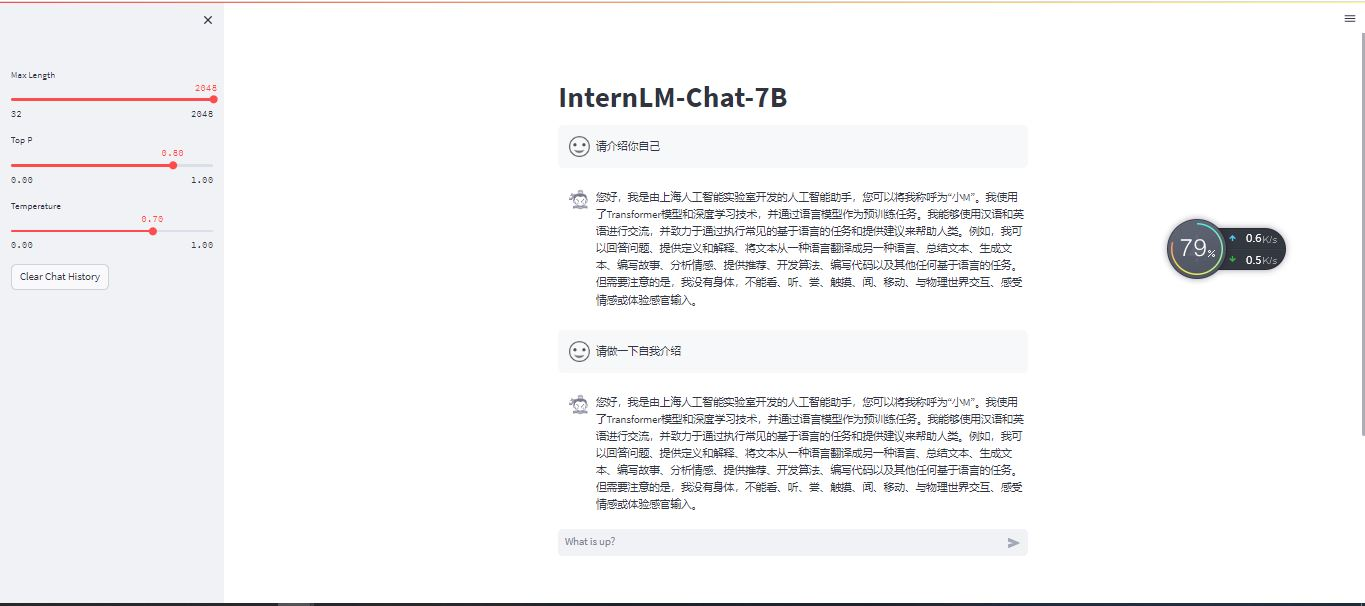

微调后

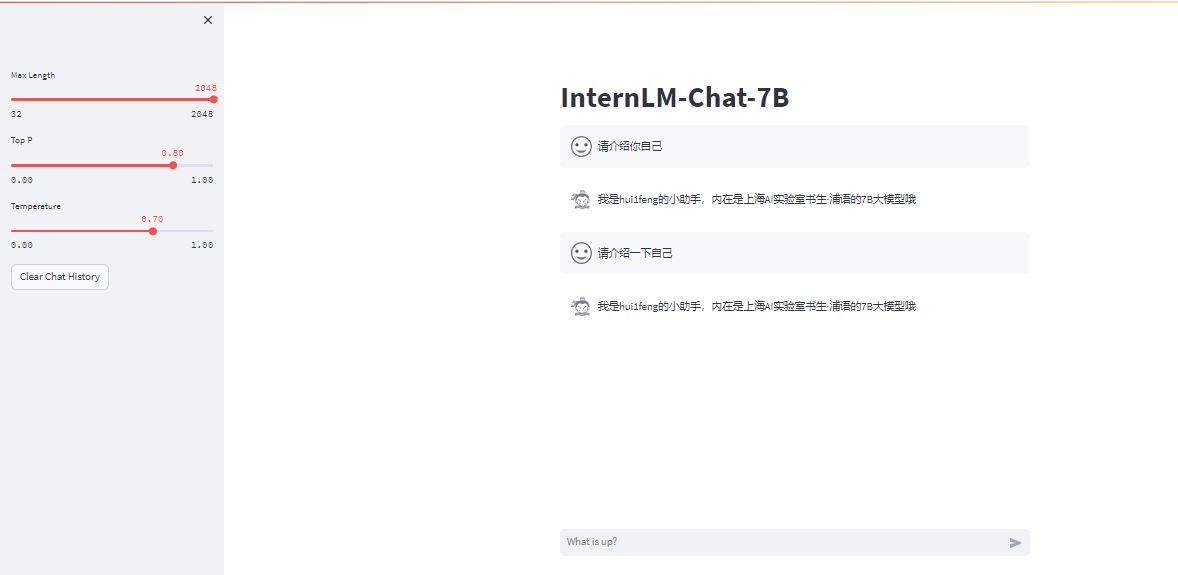

参考链接：
https://github.com/InternLM/tutorial/blob/main/xtuner/self.md

https://github.com/InternLM/tutorial/tree/main/xtuner